## How do Embeddings Change with Different Learning Rates?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from openTSNE import TSNE

# for local imports  
from pathlib import Path
import sys

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

import datasets
import quality_measures

2025-03-02 21:40:15.930410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [185]:
# this should be over in quality_measures.py, is here really just for debugging 

import scipy
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
def embedding_quality(X, Z, classes, knn=10, knn_classes=3, subsetsize=1000):
    # ensure data is in the form of a numpy array for this function 
    X = np.array(X) if not isinstance(X, np.ndarray) else X
    Z = np.array(Z) if not isinstance(Z, np.ndarray) else Z

    # measuring local embedding quality 
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    # measuring class preservation 
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    # to make sure we can handle less than 10 classes as well 
    effective_knn_classes = min(knn_classes, C - 1) 
    # print(f"effective number of classes: {effective_knn_classes}")
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    num_iterations = 10  # Number of times to compute Spearman correlation
    size_of_subset = min(X.shape[0], subsetsize)

    rho_values = []
    for _ in range(num_iterations):
        subset = np.random.choice(X.shape[0], size=size_of_subset, replace=False)
        d1 = pdist(X[subset, :])
        d2 = pdist(Z[subset, :])
        rho = scipy.stats.spearmanr(d1, d2).correlation
        rho_values.append(rho)

    rho = np.mean(rho_values) 
    # measuring global embedding quality 
    
    #subset = np.random.choice(X.shape[0], size=size_of_subset, replace=False)
    #d1 = pdist(X[subset,:])
    #d2 = pdist(Z[subset,:])
    #rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

In [121]:
X_all, y_all = datasets.load_mnist()

In [144]:
# this line is just for quick testing and should be commented out for the final experiments 
X, y = datasets.load_n_samples(500, X_all, y_all)

In [142]:
X, y = datasets.load_percentage_of_dataset(1.0, X_all, y_all)

In [140]:
learning_rates = [1, 200, 800, "auto"]
seeds = [1, 12, 42]

## Without KLD tracking

### functions for running t-sne and plotting results and embedding quality 

In [25]:
def run_tsne(data, labels, learning_rates, seeds, verbose=False): 
    """Returns embedding dictionary with keys given by learning rate and seed used to generate the embedding."""
    embedding_dict = {}
    for eta in tqdm(learning_rates): 
        for seed in tqdm(seeds): 
            tsne = TSNE(learning_rate=eta, n_jobs=-1, random_state=seed, verbose=verbose)
            embedding = tsne.fit(data)
            embedding_dict[(seed, eta)] = (embedding, labels)
    
    return embedding_dict 

In [58]:
def plot_embedding_grid(row_parameter, column_parameter, row_string, column_string, embeddings):
    """
    Plots a grid of t-SNE embeddings.

    Parameters:
    - row_parameter (list): Values to be assigned to rows (e.g., exaggeration values).
    - column_parameter (list): Values to be assigned to columns (e.g., iterations).
    - row_string (str): Label for the row axis.
    - column_string (str): Label for the column axis.
    - embeddings (dict): A dictionary where keys are (row_value, col_value) tuples,
                         and values are (embedding_array, labels).
    """

    num_rows = len(row_parameter)
    num_cols = len(column_parameter)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows), squeeze=False)

    # Plot embeddings
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]

            embedding, labels = embeddings[(row_value, col_value)]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=5)
            ax.set_xticks([])
            ax.set_yticks([])

            # Remove plot outlines 
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Add column headers (column values)
            if row_idx == 0:
                ax.set_title(f"{column_string}: {col_value}", fontsize=12, pad=10)

            # Add row labels (row values)
            if col_idx == 0:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()


### Running the embedding

In [26]:
embedding_dict = run_tsne(X, y, learning_rates, seeds, verbose=False)

100%|██████████| 5/5 [02:45<00:00, 33.01s/it]


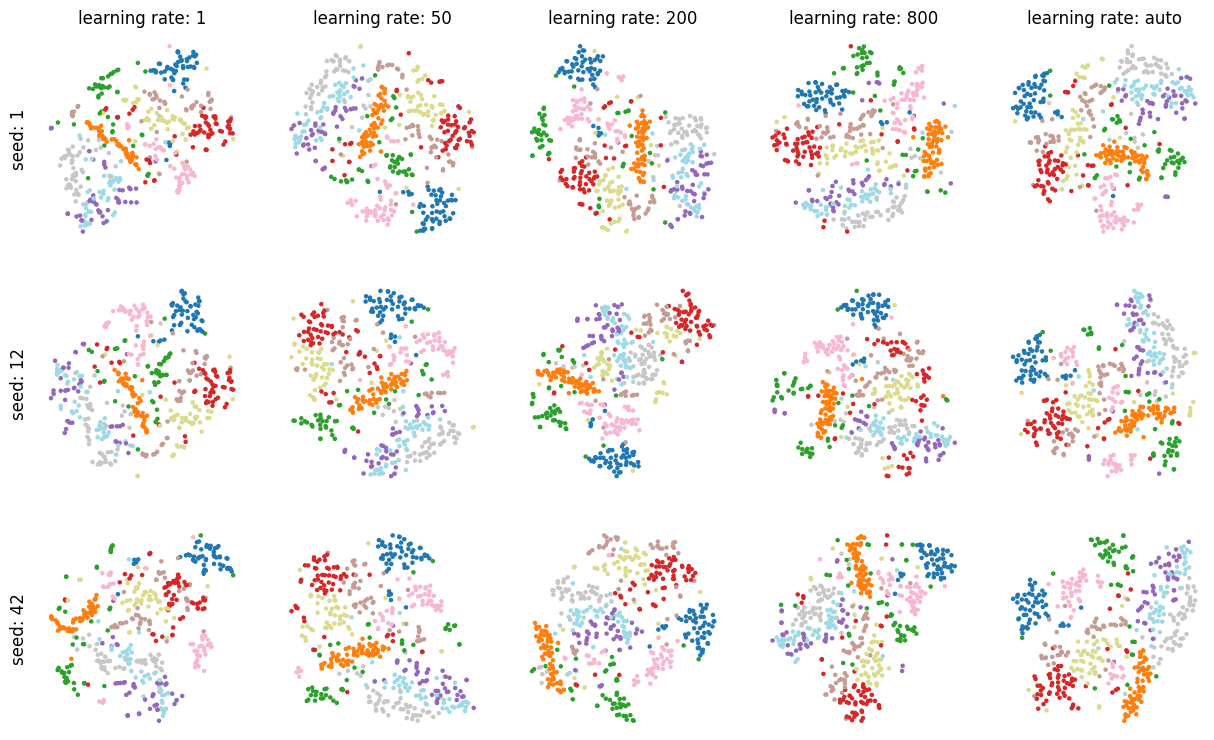

In [59]:
plot_embedding_grid(seeds, learning_rates, "seed", "learning rate", embedding_dict)

In [28]:
# this is the code from Kobak et al
from quality_measures import embedding_quality

In [ ]:
# this should be over in quality_measures.py, is here really just for debugging 

import scipy
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
def embedding_quality(X, Z, classes, knn=10, knn_classes=10, subsetsize=1000):
    # ensure data is in the form of a numpy array for this function 
    X = np.array(X) if not isinstance(X, np.ndarray) else X
    Z = np.array(Z) if not isinstance(Z, np.ndarray) else Z

    # measuring local embedding quality 
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn
    
    # measuring class preservation 
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size
    # to make sure we can handle less than 10 classes as well 
    effective_knn_classes = min(knn_classes, C - 1) 
    # print(f"effective number of classes: {effective_knn_classes}")
    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c,:] = np.mean(X[cl_inv==c,:], axis=0)
        mu2[c,:] = np.mean(Z[cl_inv==c,:], axis=0)
        
    nbrs1 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)
    nbrs2 = NearestNeighbors(n_neighbors=effective_knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)
    
    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / C / knn_classes
    
    # measuring global embedding quality 
    size_of_subset = min(X.shape[0], subsetsize)
    subset = np.random.choice(X.shape[0], size=size_of_subset, replace=False)
    d1 = pdist(X[subset,:])
    d2 = pdist(Z[subset,:])
    rho = scipy.stats.spearmanr(d1[:,None],d2[:,None]).correlation
    
    return (mnn, mnn_global, rho)

### plotting functions

In [51]:
def average_quality_measures(embedding_dict, X):
    """
    Computes the average quality measures across different seeds for each learning rate
    and stores individual seed results.

    Parameters:
        embedding_dict (dict): Dictionary with (seed, learning_rate) as keys and (embedding, labels) as values.
        X (numpy.ndarray): Original high-dimensional data.

    Returns:
        dict: Dictionary with learning_rate as keys and values being another dictionary:
              {
                  "average": (mnn_avg, mnn_global_avg, rho_avg),
                  "seeds": {seed: (mnn, mnn_global, rho), ...}
              }
    """
    quality_results = {}

    # Extract all unique learning rates
    learning_rates = set(eta for _, eta in embedding_dict.keys())

    for eta in learning_rates:
        mnn_list, mnn_global_list, rho_list = [], [], []
        seed_results = {}

        for seed in [key[0] for key in embedding_dict.keys() if key[1] == eta]:
            embedding, labels = embedding_dict[(seed, eta)]
            mnn, mnn_global, rho = embedding_quality(X, embedding, labels)

            mnn_list.append(mnn)
            mnn_global_list.append(mnn_global)
            rho_list.append(rho)

            # Store per-seed results
            seed_results[seed] = (mnn, mnn_global, rho)

        # Compute averages
        quality_results[eta] = {
            "average": (
                np.mean(mnn_list),
                np.mean(mnn_global_list),
                np.mean(rho_list)
            ),
            "seeds": seed_results
        }

    return quality_results

In [54]:
def plot_quality_measures(quality_results):
    """
    Plots three side-by-side plots for the three embedding quality measures.
    Includes individual seed results as connected grey lines and averaged results in black.

    Parameters:
        quality_results (dict): Dictionary with learning_rate as keys and values being another dictionary:
                                {
                                    "average": (mnn_avg, mnn_global_avg, rho_avg),
                                    "seeds": {seed: (mnn, mnn_global, rho), ...}
                                }
    """
    # Separate numeric and "auto" learning rates
    numeric_lrs = sorted([eta for eta in quality_results.keys() if isinstance(eta, (int, float))])
    auto_lr = ["auto"] if "auto" in quality_results else []

    # Final ordered learning rates
    learning_rates = numeric_lrs + auto_lr

    # Convert learning rates to strings for x-axis labels
    learning_rate_labels = [str(eta) for eta in learning_rates]

    # Prepare averaged data for plotting
    mnn_values = [quality_results[eta]["average"][0] for eta in learning_rates]
    mnn_global_values = [quality_results[eta]["average"][1] for eta in learning_rates]
    rho_values = [quality_results[eta]["average"][2] for eta in learning_rates]

    # Prepare per-seed data: For each seed, collect quality measures across learning_rates.
    seed_data = {}  # key: seed, value: dict with lists for each measure
    for eta in learning_rates:
        seed_results = quality_results[eta]["seeds"]
        for seed, (mnn, mnn_global, rho) in seed_results.items():
            if seed not in seed_data:
                seed_data[seed] = {'mnn': [], 'mnn_global': [], 'rho': []}
            seed_data[seed]['mnn'].append(mnn)
            seed_data[seed]['mnn_global'].append(mnn_global)
            seed_data[seed]['rho'].append(rho)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot per-seed results in grey as connected lines for each quality measure.
    for seed, data in seed_data.items():
        axes[0].plot(learning_rate_labels, data['mnn'], linestyle='-', color='grey', alpha=0.5)
        axes[1].plot(learning_rate_labels, data['mnn_global'], linestyle='-', color='grey', alpha=0.5)
        axes[2].plot(learning_rate_labels, data['rho'], linestyle='-', color='grey', alpha=0.5)

    # Plot averaged results in black with markers.
    axes[0].plot(learning_rate_labels, mnn_values, marker='o', linestyle='-', color='black', label="Average")
    axes[0].set_xlabel("Learning Rate")
    axes[0].set_ylabel("KNN")

    axes[1].plot(learning_rate_labels, mnn_global_values, marker='o', linestyle='-', color='black', label="Average")
    axes[1].set_xlabel("Learning Rate")
    axes[1].set_ylabel("KNC")

    axes[2].plot(learning_rate_labels, rho_values, marker='o', linestyle='-', color='black', label="Average")
    axes[2].set_xlabel("Learning Rate")
    axes[2].set_ylabel("CPD")

    for ax in axes:
        ax.legend()

    plt.tight_layout()
    plt.show()


### running on data!

effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9
effective number of classes: 9


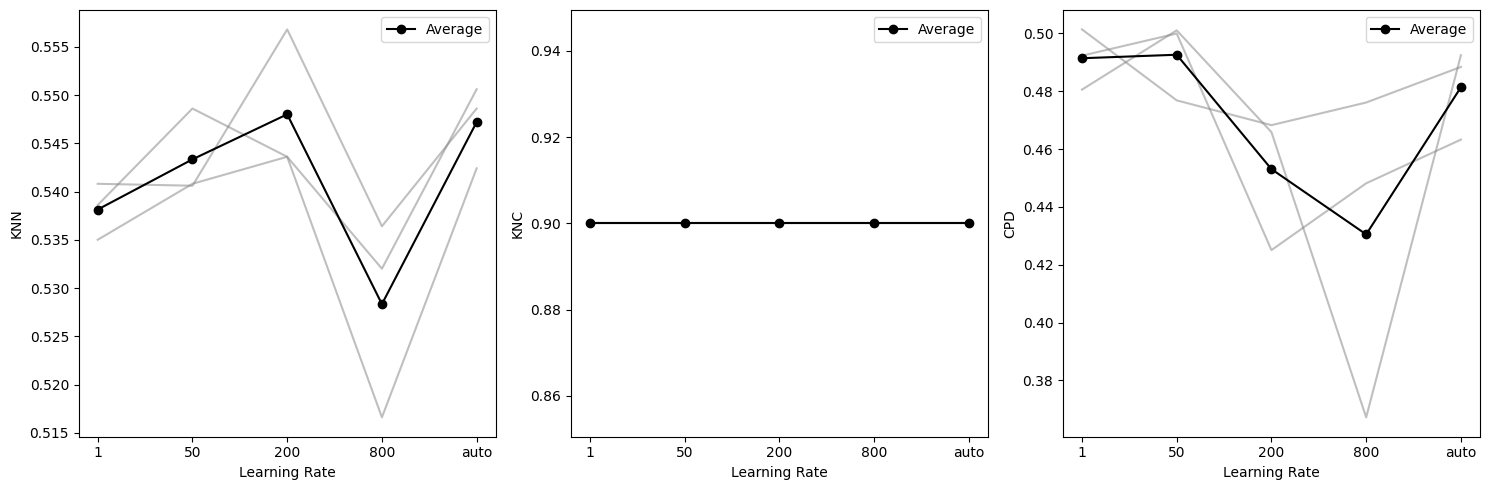

In [55]:
quality_results = average_quality_measures(embedding_dict, X)
plot_quality_measures(quality_results)

## With KLD Tracking

### alll functions (updated such that they match kld callbacks as well)

In [124]:
from openTSNE import callbacks

class KLDMonitor(callbacks.Callback):
    def __init__(self, record_every=5):
        self.record_every = record_every
        self.kl_divergences = {}
    
    def __call__(self, iteration, error, embedding):
        """
        Monitors KL divergence while ensuring unique iteration values.
        """
        # Only check every `record_every` iterations
        if iteration % self.record_every == 0:
            # in this case we are in the embedding phase  
            if iteration in self.kl_divergences or iteration > 250:
                self.kl_divergences[iteration + 250] = error 
            # in the EE phase     
            else: 
                self.kl_divergences[iteration] = error


In [165]:
def run_tsne_with_callbacks(data, labels, learning_rates, seeds, verbose=False): 
    """Returns embedding dictionary with keys given by learning rate and seed used to generate the embedding."""

    # convert to np array (from dataframe) and use float32 instead of float64
    if hasattr(data, "values"):
        data = data.values.astype(np.float32)
  
    embedding_dict = {}
    for eta in tqdm(learning_rates): 
        for seed in tqdm(seeds): 
            kld_monitor = KLDMonitor()
            tsne = TSNE(learning_rate=eta, n_jobs=-1, callbacks=kld_monitor, callbacks_every_iters=5, random_state=seed, verbose=verbose)
            embedding = tsne.fit(data)
            kld_values = kld_monitor.kl_divergences
            embedding_dict[(seed, eta)] = (embedding, labels, kld_values)
    
    return embedding_dict 

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def plot_kl_divergences(embedding_dict):
    """
    Plots the averaged KL divergence over iterations for each learning rate.
    
    For every learning rate, the function:
      - Groups the KL divergence records (dictionaries of {iteration: error}) over all seeds.
      - Averages the errors across seeds at each iteration.
      - Plots the resulting averaged curve with a label indicating the learning rate.
    
    All curves are plotted in the same figure with a legend.
    
    Parameters:
        embedding_dict (dict): Dictionary with keys (seed, learning_rate) and values
                               (embedding, labels, kld_values) where kld_values is a dict
                               mapping iteration -> error.
    """
    # Group KL divergence data by learning rate.
    kl_data = {}  # key: learning_rate, value: list of kld_values dicts (one per seed)
    for (seed, eta), (_, _, kld_values) in embedding_dict.items():
        if eta not in kl_data:
            kl_data[eta] = []
        kl_data[eta].append(kld_values)  # kld_values is now a dictionary
    
    # Order learning rates: numeric ones sorted, and then "auto" (or non-numeric) at the end.
    numeric_lrs = sorted([eta for eta in kl_data.keys() if isinstance(eta, (int, float))])
    non_numeric_lrs = [eta for eta in kl_data.keys() if not isinstance(eta, (int, float))]
    ordered_lrs = numeric_lrs + non_numeric_lrs
    
    plt.figure(figsize=(8, 6))
    
    # Process each learning rate
    for eta in ordered_lrs:
        # List of kld_values dicts for each seed
        seed_kld_dicts = kl_data[eta]
        
        # Create a mapping: iteration -> list of errors from all seeds.
        iter_errors = {}
        for kld_dict in seed_kld_dicts:
            for iteration, error in kld_dict.items():  # Iterate over dictionary items
                if iteration not in iter_errors:
                    iter_errors[iteration] = []
                iter_errors[iteration].append(error)
        
        # Sort iterations and compute the average error at each iteration.
        iterations = sorted(iter_errors.keys())
        avg_errors = [np.mean(iter_errors[it]) for it in iterations]
        
        # Plot the averaged KL divergence curve for this learning rate.
        plt.plot(iterations, avg_errors, label=f"lr={eta}")
    
    plt.xlabel("Iteration")
    plt.ylabel("KL Divergence")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [127]:
def plot_embedding_grid(row_parameter, column_parameter, row_string, column_string, embeddings):
    """
    Plots a grid of t-SNE embeddings.

    Parameters:
    - row_parameter (list): Values to be assigned to rows (e.g., exaggeration values).
    - column_parameter (list): Values to be assigned to columns (e.g., iterations).
    - row_string (str): Label for the row axis.
    - column_string (str): Label for the column axis.
    - embeddings (dict): A dictionary where keys are (row_value, col_value) tuples,
                         and values are (embedding_array, labels, kld_values).
    """
    num_rows = len(row_parameter)
    num_cols = len(column_parameter)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows), squeeze=False)

    # Plot embeddings
    for row_idx, row_value in enumerate(row_parameter):
        for col_idx, col_value in enumerate(column_parameter):
            ax = axes[row_idx, col_idx]

            # Unpack three elements; kld_values is ignored here.
            embedding, labels, _ = embeddings[(row_value, col_value)]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap="tab20", s=5)
            ax.set_xticks([])
            ax.set_yticks([])

            # Remove plot outlines 
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Add column headers (column values)
            if row_idx == 0:
                ax.set_title(f"{column_string}: {col_value}", fontsize=12, pad=10)

            # Add row labels (row values)
            if col_idx == 0:
                ax.set_ylabel(f"{row_string}: {row_value}", fontsize=12, labelpad=10)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()


In [186]:
def average_quality_measures(embedding_dict, X):
    """
    Computes the average quality measures across different seeds for each learning rate
    and stores individual seed results.

    Parameters:
        embedding_dict (dict): Dictionary with (seed, learning_rate) as keys and
                               (embedding, labels, kld_values) as values.
        X (numpy.ndarray): Original high-dimensional data.

    Returns:
        dict: Dictionary with learning_rate as keys and values being another dictionary:
              {
                  "average": (mnn_avg, mnn_global_avg, rho_avg),
                  "seeds": {seed: (mnn, mnn_global, rho), ...}
              }
    """
    quality_results = {}

    # Extract all unique learning rates
    learning_rates = set(eta for _, eta in embedding_dict.keys())

    for eta in learning_rates:
        mnn_list, mnn_global_list, rho_list = [], [], []
        seed_results = {}

        for seed in [key[0] for key in embedding_dict.keys() if key[1] == eta]:
            # Unpack three elements; ignore kld_values
            embedding, labels, _ = embedding_dict[(seed, eta)]
            mnn, mnn_global, rho = embedding_quality(X, embedding, labels)

            mnn_list.append(mnn)
            mnn_global_list.append(mnn_global)
            rho_list.append(rho)

            # Store per-seed results
            seed_results[seed] = (mnn, mnn_global, rho)

        # Compute averages
        quality_results[eta] = {
            "average": (
                np.mean(mnn_list),
                np.mean(mnn_global_list),
                np.mean(rho_list)
            ),
            "seeds": seed_results
        }

    return quality_results


### running on mnist

In [146]:
X_all.shape

(70000, 50)

In [161]:
X, y = datasets.load_n_samples(70000, X_all, y_all)

In [166]:
embedding_dict = run_tsne_with_callbacks(X_all, y_all, learning_rates=learning_rates, seeds=seeds, verbose=False)

100%|██████████| 4/4 [30:25<00:00, 456.39s/it]


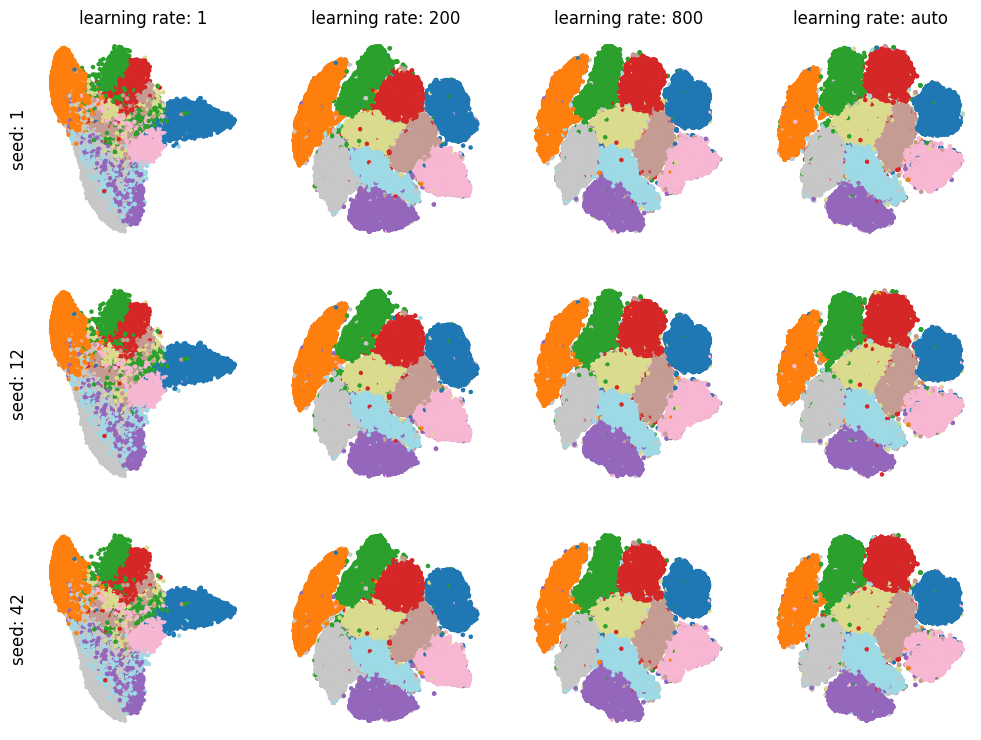

In [167]:
plot_embedding_grid(seeds, learning_rates, "seed", "learning rate", embedding_dict)

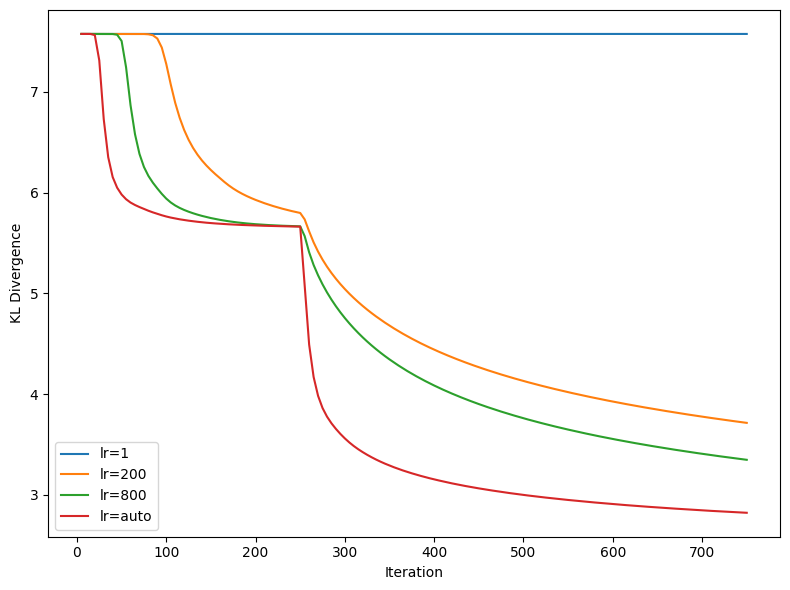

In [168]:
plot_kl_divergences(embedding_dict)

In [169]:
quality_results = average_quality_measures(embedding_dict, X)

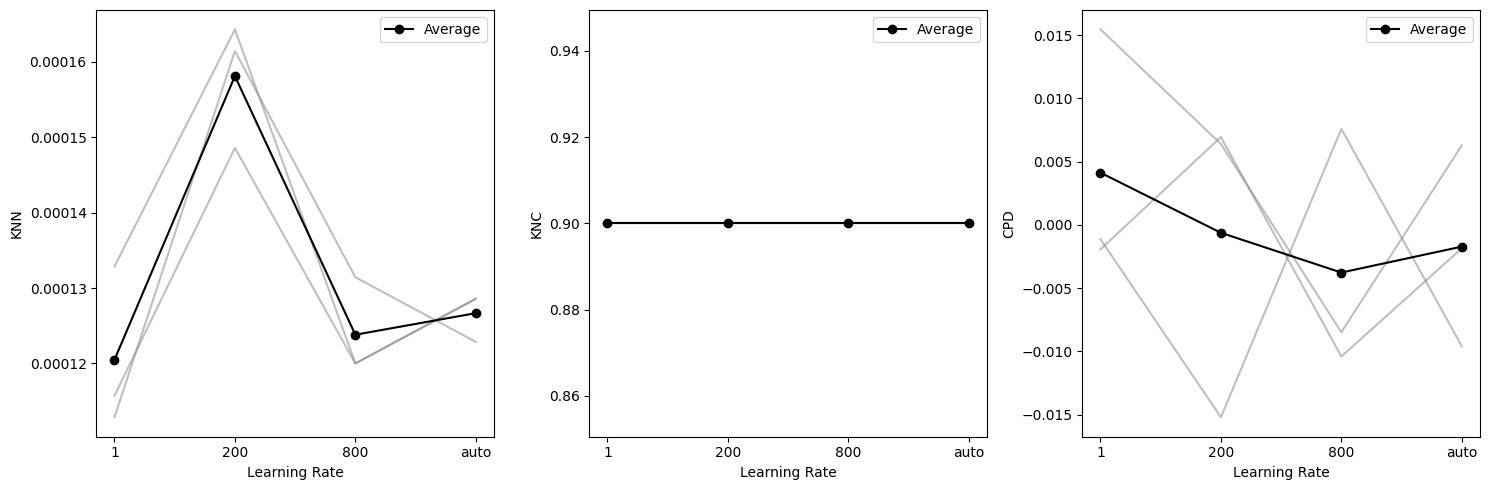

In [170]:
plot_quality_measures(quality_results)

In [171]:
embedding_dict2 = run_tsne_with_callbacks(X_all, y_all, learning_rates=[1, 200, 800, "auto", 10000], seeds=[12, 42], verbose=False)

100%|██████████| 5/5 [26:15<00:00, 315.11s/it]


KeyError: (1, 1)

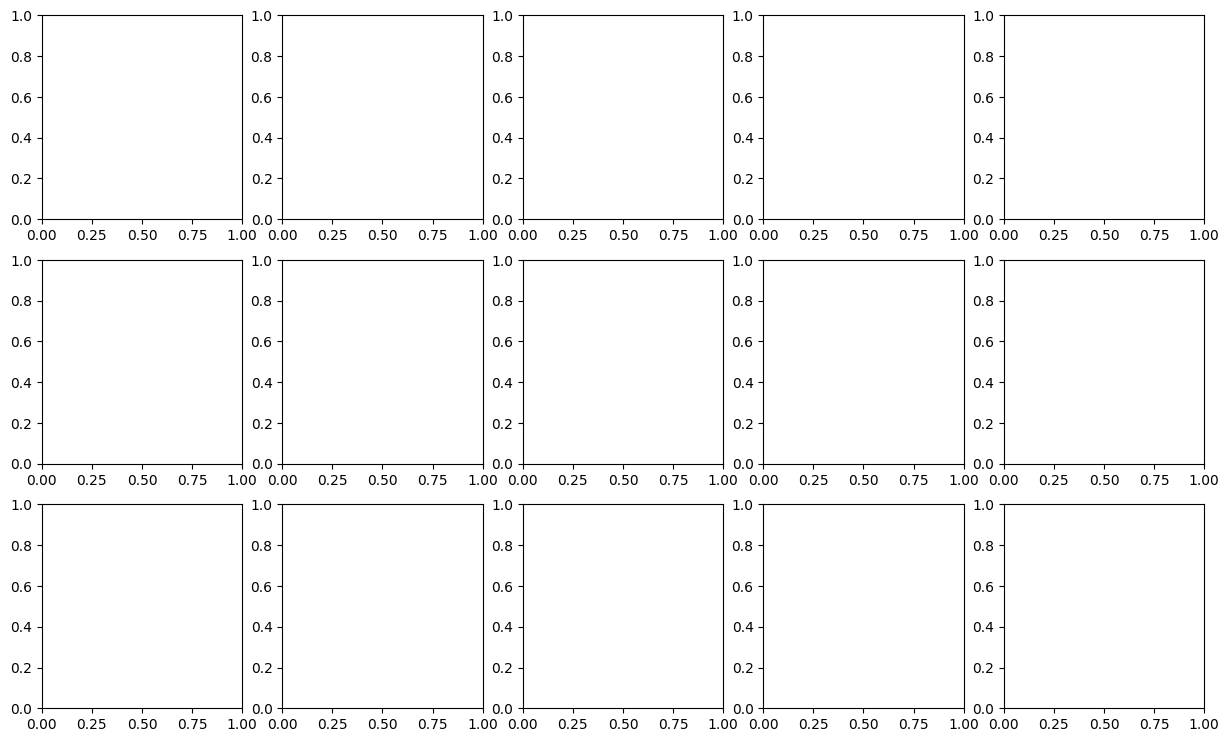

In [175]:
plot_embedding_grid(seeds, column_parameter=[1, 200, 800, "auto", 10000],row_string="seed", column_string="learning rate", embeddings=embedding_dict2)

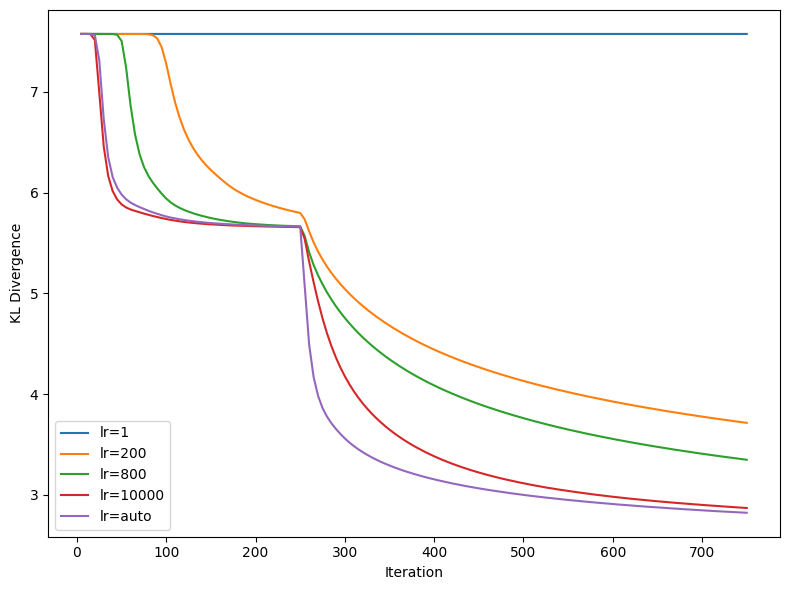

In [176]:
plot_kl_divergences(embedding_dict2)

In [177]:
quality_results2 = average_quality_measures(embedding_dict2, X)

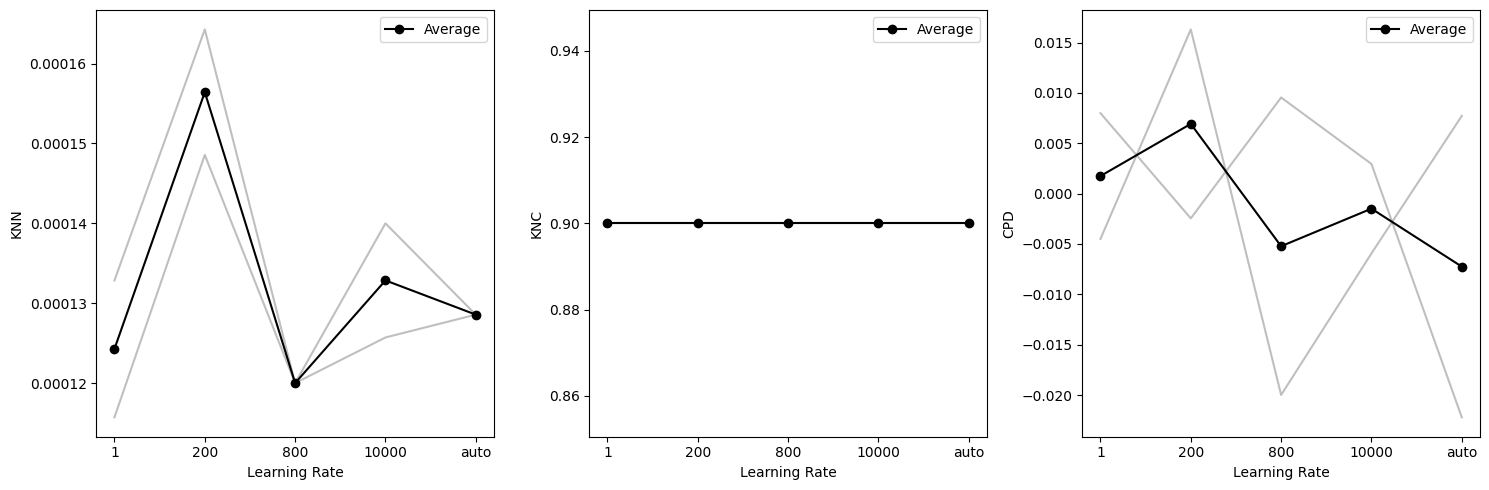

In [178]:
plot_quality_measures(quality_results2)

100%|██████████| 4/4 [28:14<00:00, 423.54s/it]


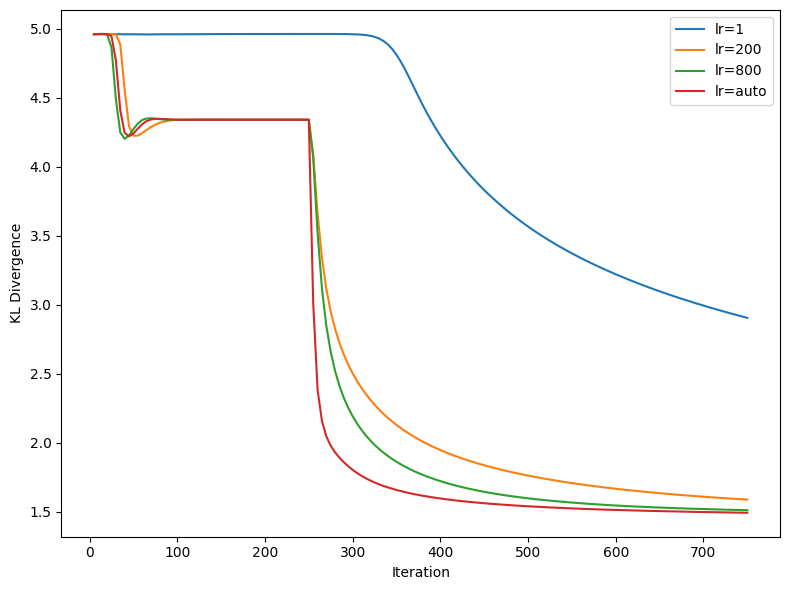

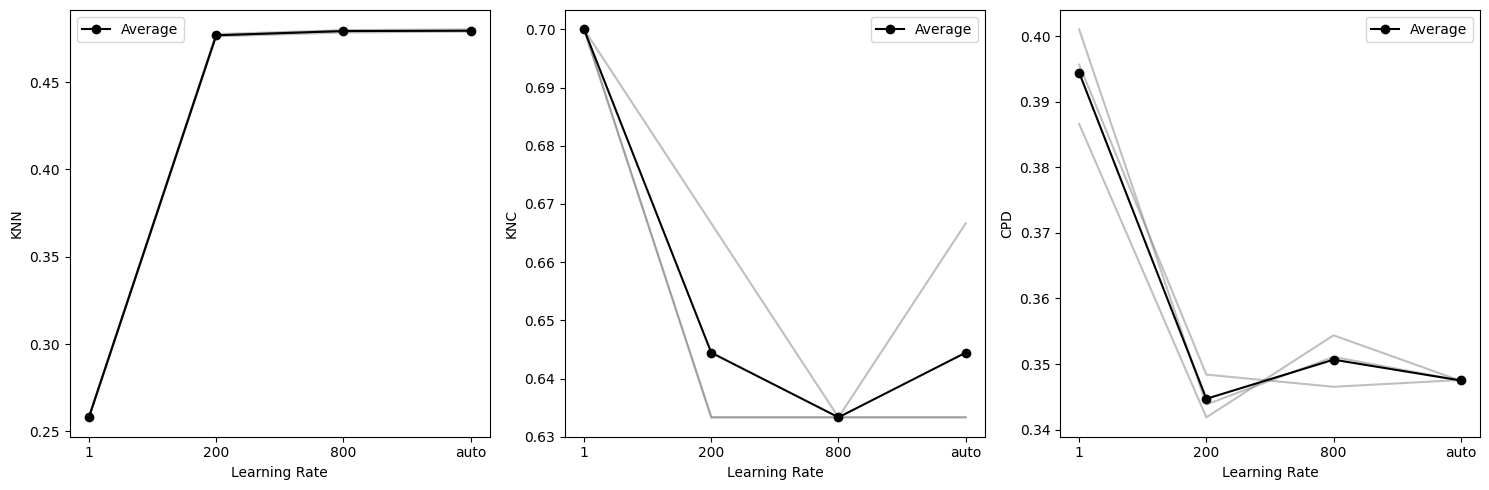

In [188]:
X, y = datasets.load_n_samples(5000, X_all, y_all)
embedding_dict3 = run_tsne_with_callbacks(X, y, learning_rates=learning_rates, seeds=seeds, verbose=False)
plot_kl_divergences(embedding_dict3)
quality_results3 = average_quality_measures(embedding_dict3, X)
plot_quality_measures(quality_results3)